In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import tempfile

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, \
                            precision_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow import keras

In [3]:
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
le = LabelEncoder()

customer_data['Churn'] = le.fit_transform(customer_data['Churn'])

In [6]:
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [7]:
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [8]:
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)
customer_data.drop('CustomerID', axis=1, inplace=True)

customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [9]:
print('Total: {}\n    Positive: {:.2f}\n    Negative: {:.2f}\n'.format(customer_data.shape[0],
                                                         customer_data['Churn'].value_counts(normalize=True)[1],
                                                         customer_data['Churn'].value_counts(normalize=True)[0]))

Total: 7032
    Positive: 0.27
    Negative: 0.73



In [10]:
target = customer_data.pop('Churn')

customer_data_dum = pd.get_dummies(customer_data, columns=customer_data.select_dtypes(include='object').columns,
                                                   drop_first=True)

customer_data_dum['Churn'] = target

In [11]:
train_data, test_data = train_test_split(customer_data_dum, test_size=0.2, stratify=customer_data_dum['Churn'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Churn'])

In [12]:
train_data.head()

,Tenure,MonthlyCharges,TotalCharges,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_CrCa-A,PaymentMethod_ElCh,PaymentMethod_MaCh,Churn
378,61,89.65,5308.70,0,0,0,0,1,0,1,...,1,0,1,0,1,0,0,1,0,0
1532,14,19.60,300.40,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1149,13,96.65,1162.85,1,0,1,1,1,0,0,...,1,0,1,0,0,1,0,0,1,1
2686,19,79.85,1471.75,1,1,0,0,1,0,1,...,0,0,0,0,0,1,0,1,0,1
2944,12,50.95,605.75,1,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0


In [13]:
train_labels = np.array(train_data.pop('Churn'))
bool_train_labels = train_labels != 0
validation_labels = np.array(validation_data.pop('Churn'))
test_labels = np.array(test_data.pop('Churn'))

train_features = np.array(train_data)
validation_features = np.array(validation_data)
test_features = np.array(test_data)

In [14]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', validation_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', validation_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4500,)
Validation labels shape: (1125,)
Test labels shape: (1407,)
Training features shape: (4500, 30)
Validation features shape: (1125, 30)
Test features shape: (1407, 30)


/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Negative distribution')

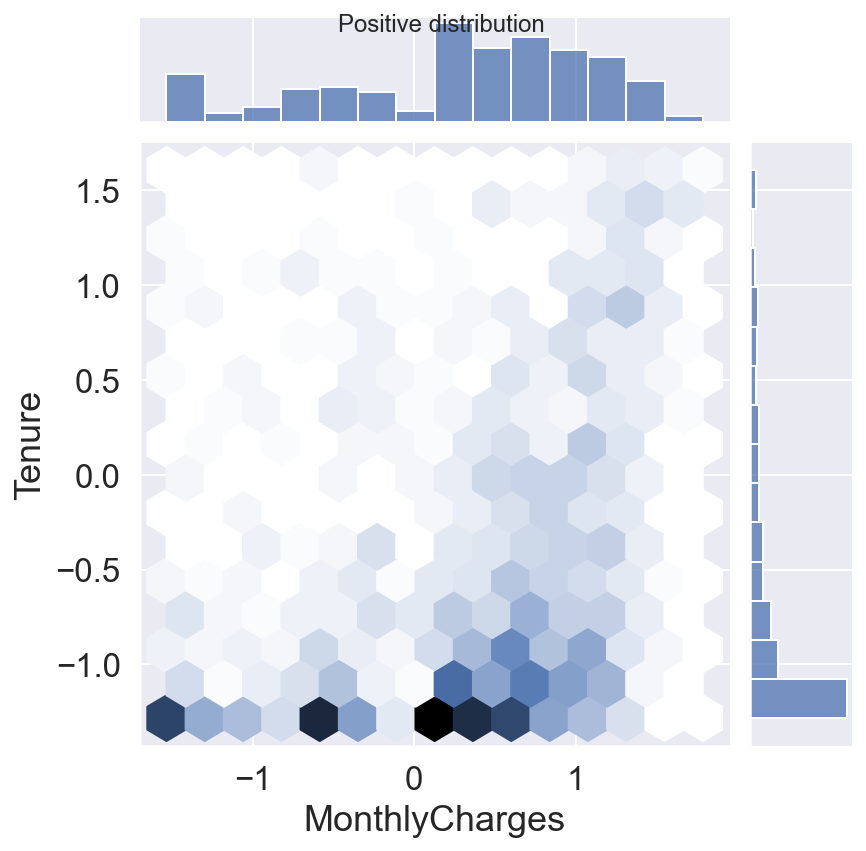

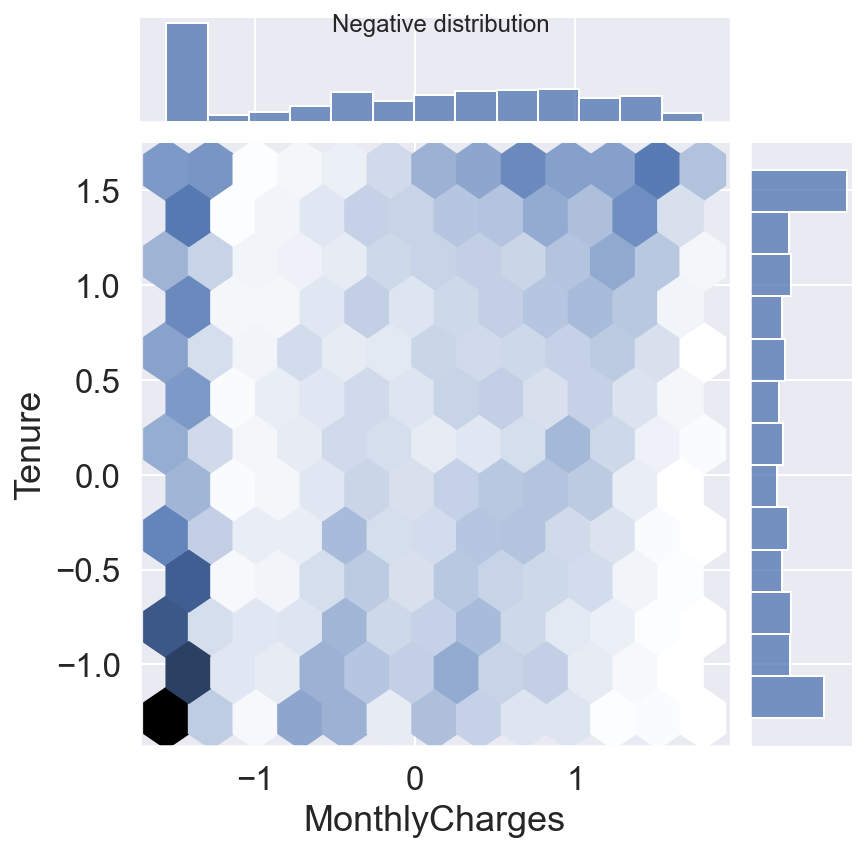

In [15]:
pos_data = pd.DataFrame(train_features[bool_train_labels], columns=train_data.columns)
neg_data = pd.DataFrame(train_features[~bool_train_labels], columns=train_data.columns)

sns.jointplot(pos_data['MonthlyCharges'], pos_data['Tenure'], kind='hex')
plt.suptitle('Positive distribution')

sns.jointplot(neg_data['MonthlyCharges'], neg_data['Tenure'], kind='hex')
plt.suptitle('Negative distribution')

In [16]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.AUC(name='prc', curve='PR'),]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(24, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.5),
                              keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.4),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias),
                             ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

In [17]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                  verbose=1,
                                                  patience=10,
                                                  mode='max',
                                                  restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                744       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


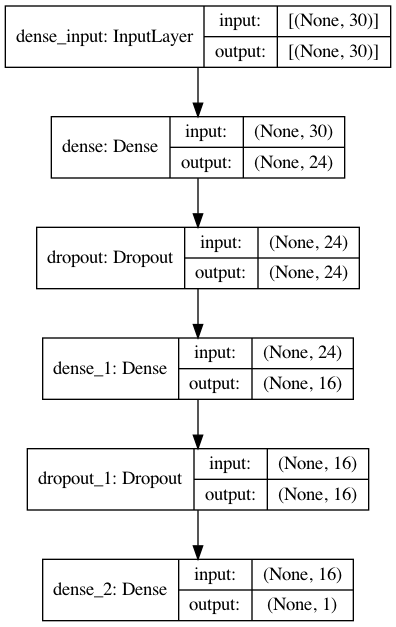

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB')

In [19]:
model.predict(train_features[:10])

array([[0.3171386 ],
       [0.2734921 ],
       [0.35483122],
       [0.47913948],
       [0.2829023 ],
       [0.38372883],
       [0.29730526],
       [0.3850585 ],
       [0.38758853],
       [0.2931059 ]], dtype=float32)

In [20]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.6547


In [21]:
neg, pos = np.bincount(customer_data_dum['Churn'])

total = neg + pos

initial_bias = np.log([pos/neg])
initial_bias

array([-1.01611428])

In [22]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.27615857],
       [0.3750562 ],
       [0.24295273],
       [0.13951904],
       [0.1823878 ],
       [0.44781142],
       [0.2551644 ],
       [0.20902342],
       [0.25228408],
       [0.24228904]], dtype=float32)

In [23]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.6316


In [24]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [25]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(validation_features, validation_labels),
                              verbose=0)

In [26]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features,
                                 train_labels,
                                 batch_size=BATCH_SIZE,
                                 epochs=20,
                                 validation_data=(validation_features, validation_labels),
                                 verbose=0)

In [27]:
def PlotLoss(history, label, color):
    plt.semilogy(history.epoch, history.history['loss'], color=color, label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=color, label='Validation ' + label, ls='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

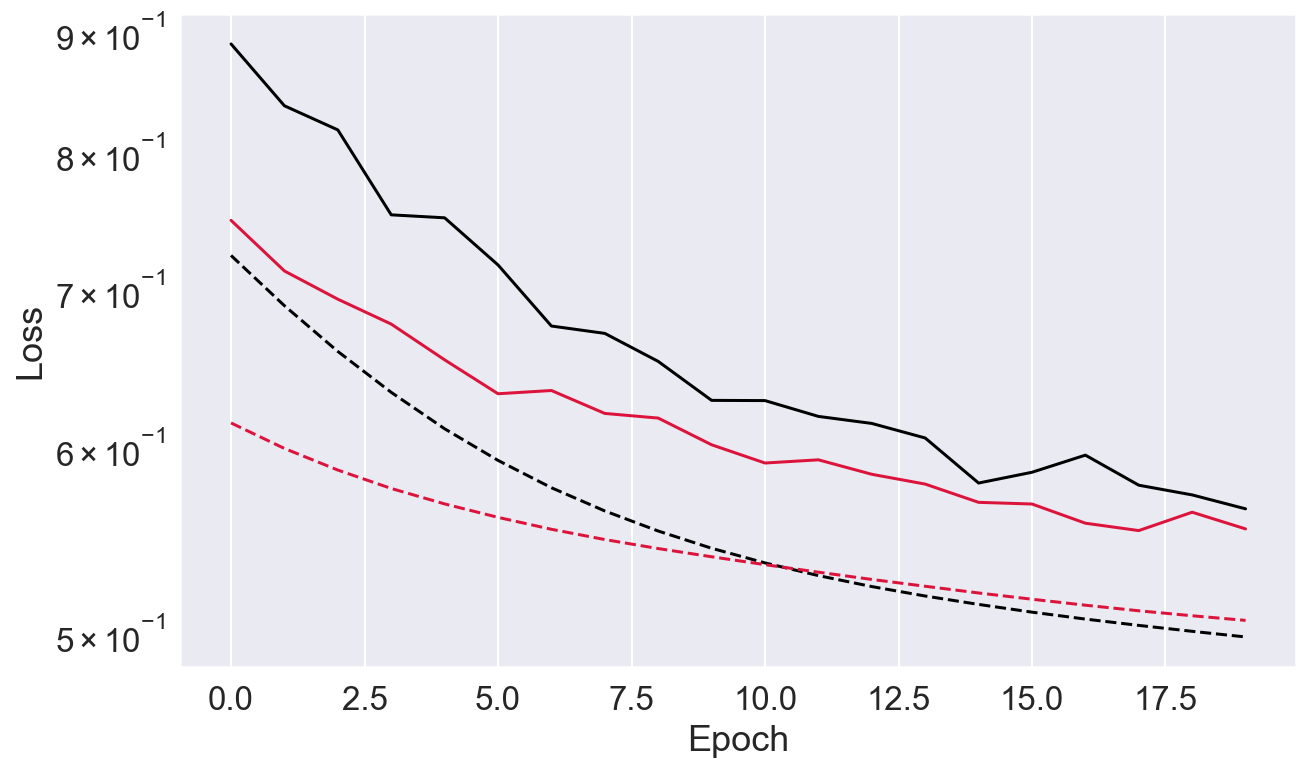

In [28]:
plt.figure(figsize=(10, 6))
PlotLoss(zero_bias_history, 'Zero Bias', 'black')
PlotLoss(careful_bias_history, 'Careful Bias', 'crimson')

In [29]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(validation_features, validation_labels))

Epoch 1/100
3/3 [==============================] - 2s 357ms/step - loss: 0.7479 - tp: 140.0000 - fp: 648.0000 - tn: 3482.0000 - fn: 1355.0000 - accuracy: 0.6439 - precision: 0.1777 - recall: 0.0936 - auc: 0.5032 - prc: 0.2494 - val_loss: 0.6145 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 825.0000 - val_fn: 299.0000 - val_accuracy: 0.7333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3827 - val_prc: 0.2055
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 0.7240 - tp: 140.0000 - fp: 586.0000 - tn: 2718.0000 - fn: 1056.0000 - accuracy: 0.6351 - precision: 0.1928 - recall: 0.1171 - auc: 0.4585 - prc: 0.2345 - val_loss: 0.6001 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 826.0000 - val_fn: 299.0000 - val_accuracy: 0.7342 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4372 - val_prc: 0.2301
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6875 - tp: 133.0000 - fp: 498.0000 - tn: 2806.0000 - fn: 

3/3 [==============================] - 0s 16ms/step - loss: 0.5515 - tp: 158.0000 - fp: 186.0000 - tn: 3118.0000 - fn: 1038.0000 - accuracy: 0.7280 - precision: 0.4593 - recall: 0.1321 - auc: 0.6644 - prc: 0.3919 - val_loss: 0.5075 - val_tp: 5.0000 - val_fp: 4.0000 - val_tn: 822.0000 - val_fn: 294.0000 - val_accuracy: 0.7351 - val_precision: 0.5556 - val_recall: 0.0167 - val_auc: 0.7612 - val_prc: 0.5140
Epoch 21/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5361 - tp: 197.0000 - fp: 155.0000 - tn: 3149.0000 - fn: 999.0000 - accuracy: 0.7436 - precision: 0.5597 - recall: 0.1647 - auc: 0.6865 - prc: 0.4359 - val_loss: 0.5050 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 822.0000 - val_fn: 293.0000 - val_accuracy: 0.7360 - val_precision: 0.6000 - val_recall: 0.0201 - val_auc: 0.7634 - val_prc: 0.5178
Epoch 22/100
3/3 [==============================] - 0s 15ms/step - loss: 0.5389 - tp: 201.0000 - fp: 192.0000 - tn: 3112.0000 - fn: 995.0000 - accuracy: 0.7362 - precision:

3/3 [==============================] - 0s 14ms/step - loss: 0.4970 - tp: 282.0000 - fp: 182.0000 - tn: 3122.0000 - fn: 914.0000 - accuracy: 0.7564 - precision: 0.6078 - recall: 0.2358 - auc: 0.7579 - prc: 0.5165 - val_loss: 0.4737 - val_tp: 39.0000 - val_fp: 13.0000 - val_tn: 813.0000 - val_fn: 260.0000 - val_accuracy: 0.7573 - val_precision: 0.7500 - val_recall: 0.1304 - val_auc: 0.7981 - val_prc: 0.5641
Epoch 40/100
3/3 [==============================] - 0s 17ms/step - loss: 0.4971 - tp: 290.0000 - fp: 214.0000 - tn: 3090.0000 - fn: 906.0000 - accuracy: 0.7511 - precision: 0.5754 - recall: 0.2425 - auc: 0.7575 - prc: 0.5148 - val_loss: 0.4724 - val_tp: 45.0000 - val_fp: 16.0000 - val_tn: 810.0000 - val_fn: 254.0000 - val_accuracy: 0.7600 - val_precision: 0.7377 - val_recall: 0.1505 - val_auc: 0.7988 - val_prc: 0.5653
Epoch 41/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4912 - tp: 318.0000 - fp: 208.0000 - tn: 3096.0000 - fn: 878.0000 - accuracy: 0.7587 - precisi

3/3 [==============================] - 0s 14ms/step - loss: 0.4773 - tp: 349.0000 - fp: 212.0000 - tn: 3092.0000 - fn: 847.0000 - accuracy: 0.7647 - precision: 0.6221 - recall: 0.2918 - auc: 0.7841 - prc: 0.5403 - val_loss: 0.4593 - val_tp: 78.0000 - val_fp: 32.0000 - val_tn: 794.0000 - val_fn: 221.0000 - val_accuracy: 0.7751 - val_precision: 0.7091 - val_recall: 0.2609 - val_auc: 0.8089 - val_prc: 0.5845
Epoch 59/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4780 - tp: 361.0000 - fp: 226.0000 - tn: 3078.0000 - fn: 835.0000 - accuracy: 0.7642 - precision: 0.6150 - recall: 0.3018 - auc: 0.7868 - prc: 0.5354 - val_loss: 0.4588 - val_tp: 80.0000 - val_fp: 33.0000 - val_tn: 793.0000 - val_fn: 219.0000 - val_accuracy: 0.7760 - val_precision: 0.7080 - val_recall: 0.2676 - val_auc: 0.8094 - val_prc: 0.5849
Epoch 60/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4774 - tp: 375.0000 - fp: 223.0000 - tn: 3081.0000 - fn: 821.0000 - accuracy: 0.7680 - precisi

3/3 [==============================] - 0s 14ms/step - loss: 0.4649 - tp: 397.0000 - fp: 237.0000 - tn: 3067.0000 - fn: 799.0000 - accuracy: 0.7698 - precision: 0.6262 - recall: 0.3319 - auc: 0.8015 - prc: 0.5666 - val_loss: 0.4532 - val_tp: 83.0000 - val_fp: 39.0000 - val_tn: 787.0000 - val_fn: 216.0000 - val_accuracy: 0.7733 - val_precision: 0.6803 - val_recall: 0.2776 - val_auc: 0.8152 - val_prc: 0.6020
Epoch 78/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4616 - tp: 399.0000 - fp: 229.0000 - tn: 3075.0000 - fn: 797.0000 - accuracy: 0.7720 - precision: 0.6354 - recall: 0.3336 - auc: 0.8040 - prc: 0.5637 - val_loss: 0.4531 - val_tp: 83.0000 - val_fp: 38.0000 - val_tn: 788.0000 - val_fn: 216.0000 - val_accuracy: 0.7742 - val_precision: 0.6860 - val_recall: 0.2776 - val_auc: 0.8154 - val_prc: 0.6047
Epoch 79/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4623 - tp: 411.0000 - fp: 231.0000 - tn: 3073.0000 - fn: 785.0000 - accuracy: 0.7742 - precisi

3/3 [==============================] - 0s 13ms/step - loss: 0.4661 - tp: 390.0000 - fp: 251.0000 - tn: 3053.0000 - fn: 806.0000 - accuracy: 0.7651 - precision: 0.6084 - recall: 0.3261 - auc: 0.8079 - prc: 0.5526 - val_loss: 0.4508 - val_tp: 84.0000 - val_fp: 36.0000 - val_tn: 790.0000 - val_fn: 215.0000 - val_accuracy: 0.7769 - val_precision: 0.7000 - val_recall: 0.2809 - val_auc: 0.8186 - val_prc: 0.6168
Epoch 97/100
3/3 [==============================] - 0s 13ms/step - loss: 0.4608 - tp: 416.0000 - fp: 260.0000 - tn: 3044.0000 - fn: 780.0000 - accuracy: 0.7689 - precision: 0.6154 - recall: 0.3478 - auc: 0.8067 - prc: 0.5626 - val_loss: 0.4510 - val_tp: 81.0000 - val_fp: 35.0000 - val_tn: 791.0000 - val_fn: 218.0000 - val_accuracy: 0.7751 - val_precision: 0.6983 - val_recall: 0.2709 - val_auc: 0.8188 - val_prc: 0.6175
Epoch 98/100
3/3 [==============================] - 0s 13ms/step - loss: 0.4518 - tp: 410.0000 - fp: 223.0000 - tn: 3081.0000 - fn: 786.0000 - accuracy: 0.7758 - precisi

In [30]:
def PlotMetrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace('_', ' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color='black', label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color='black', ls='--', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

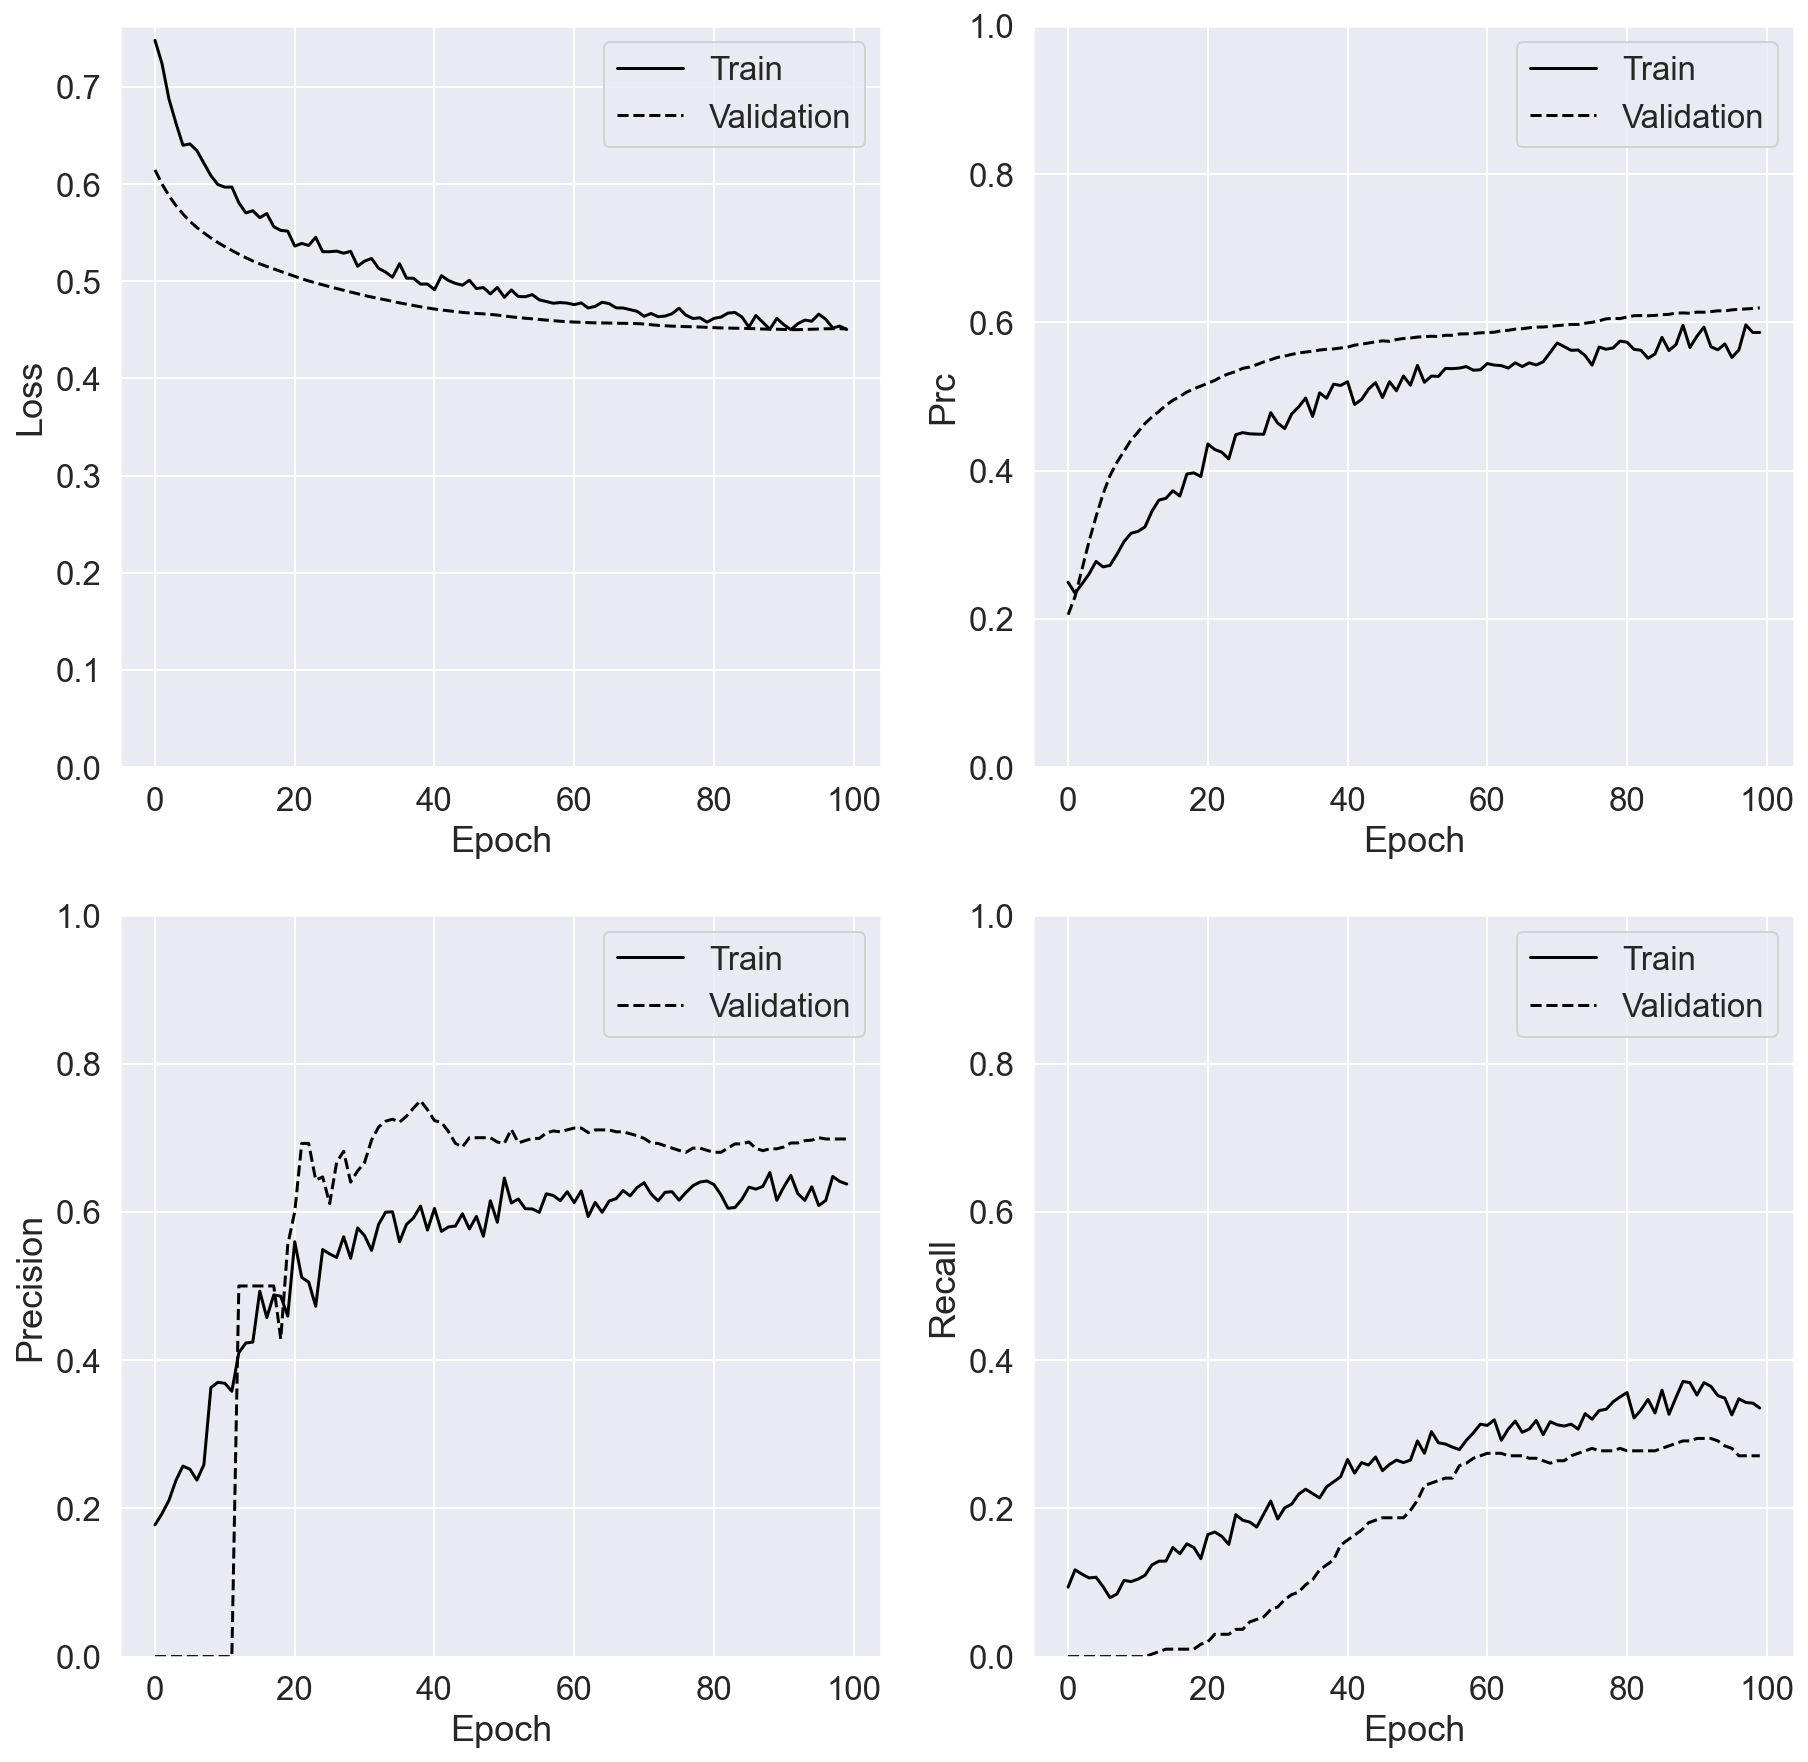

In [31]:
PlotMetrics(baseline_history)

In [32]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [33]:
def ConfMatrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

loss :  0.4400239884853363
tp :  116.0
fp :  39.0
tn :  994.0
fn :  258.0
accuracy :  0.7889125943183899
precision :  0.7483870983123779
recall :  0.31016042828559875
auc :  0.8342362642288208
prc :  0.6240988373756409


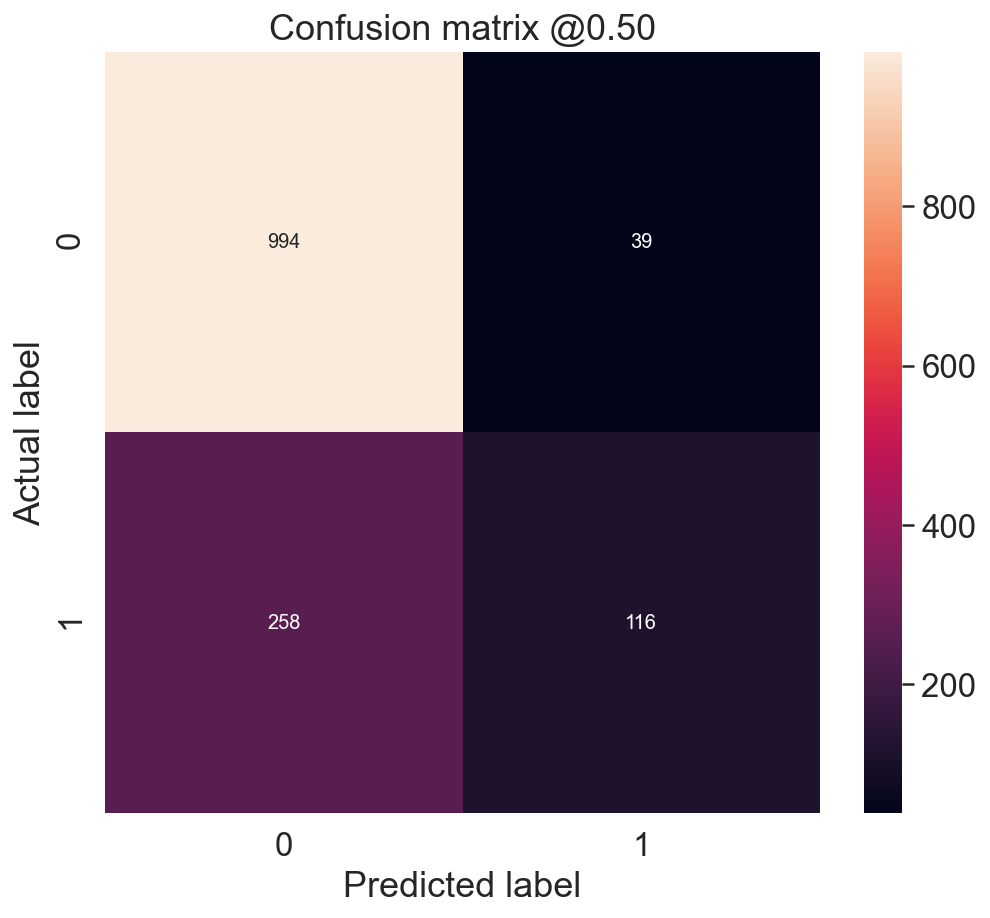

In [34]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_baseline)

In [35]:
def PlotROC(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, lw=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 100.5])
    plt.ylim([-0.5, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

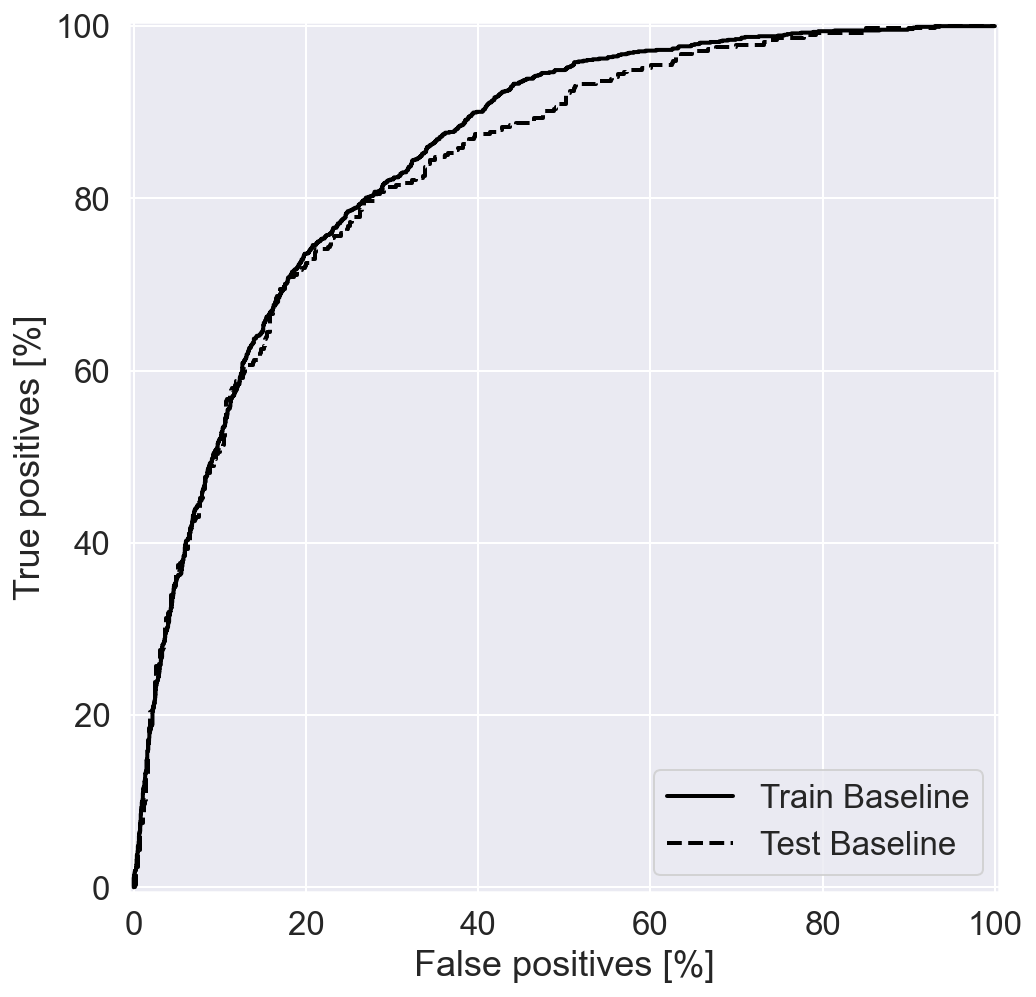

In [36]:
plt.figure(figsize=(8, 8))
PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower right')

In [37]:
def PlotPRC(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, lw=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

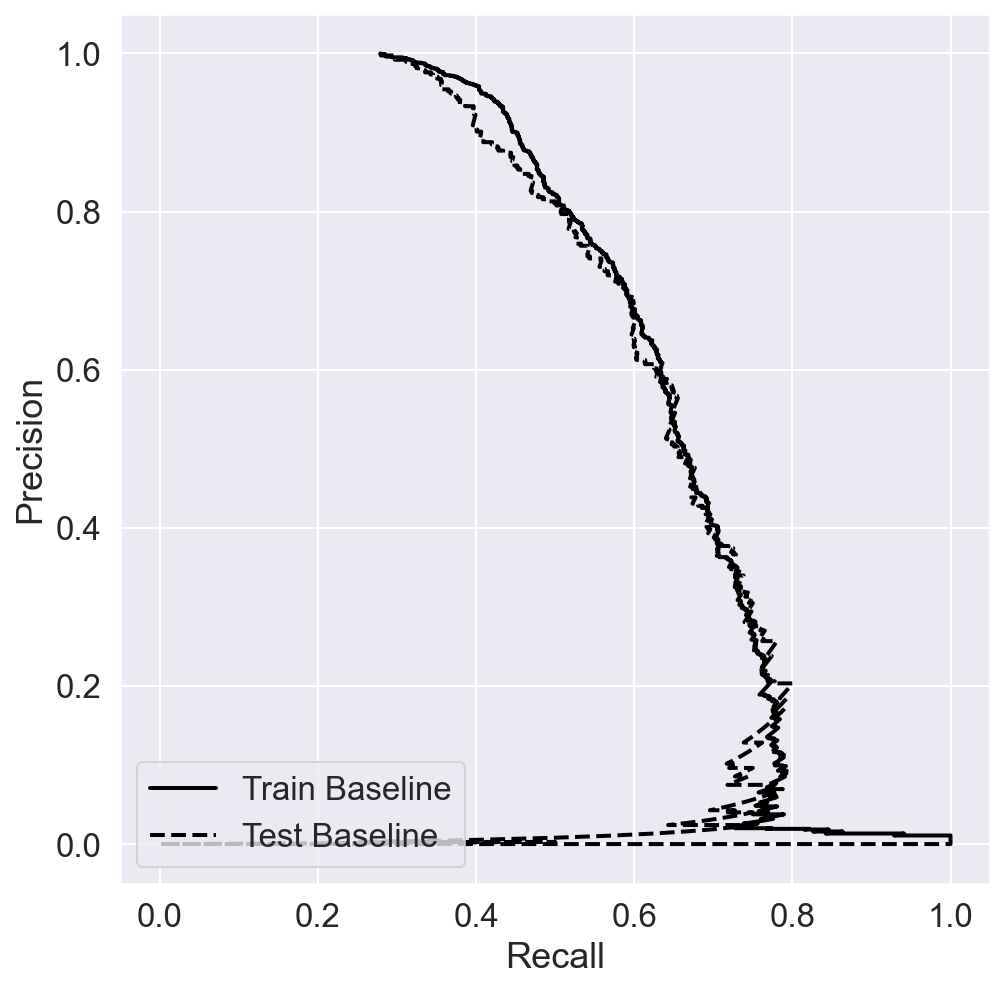

In [38]:
plt.figure(figsize=(8, 8))
PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower left')

In [39]:
weight_for_0 = (1/neg)*(total/2)
weight_for_1 = (1/pos)*(total/2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


In [40]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features,
                                      train_labels,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=[early_stopping],
                                      validation_data=(validation_features, validation_labels),
                                      class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
3/3 [==============================] - 2s 338ms/step - loss: 0.9570 - tp: 255.0000 - fp: 668.0000 - tn: 3669.0000 - fn: 1315.0000 - accuracy: 0.6643 - precision: 0.2763 - recall: 0.1624 - auc: 0.5534 - prc: 0.2775 - val_loss: 0.6181 - val_tp: 0.0000e+00 - val_fp: 6.0000 - val_tn: 820.0000 - val_fn: 299.0000 - val_accuracy: 0.7289 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3778 - val_prc: 0.2040
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.9344 - tp: 151.0000 - fp: 680.0000 - tn: 2624.0000 - fn: 1045.0000 - accuracy: 0.6167 - precision: 0.1817 - recall: 0.1263 - auc: 0.4579 - prc: 0.2327 - val_loss: 0.6054 - val_tp: 1.0000 - val_fp: 6.0000 - val_tn: 820.0000 - val_fn: 298.0000 - val_accuracy: 0.7298 - val_precision: 0.1429 - val_recall: 0.0033 - val_auc: 0.4238 - val_prc: 0.2247
Epoch 3/1

3/3 [==============================] - 0s 18ms/step - loss: 0.6835 - tp: 582.0000 - fp: 863.0000 - tn: 2441.0000 - fn: 614.0000 - accuracy: 0.6718 - precision: 0.4028 - recall: 0.4866 - auc: 0.6588 - prc: 0.4138 - val_loss: 0.5371 - val_tp: 158.0000 - val_fp: 128.0000 - val_tn: 698.0000 - val_fn: 141.0000 - val_accuracy: 0.7609 - val_precision: 0.5524 - val_recall: 0.5284 - val_auc: 0.7729 - val_prc: 0.5376
Epoch 20/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6647 - tp: 593.0000 - fp: 780.0000 - tn: 2524.0000 - fn: 603.0000 - accuracy: 0.6927 - precision: 0.4319 - recall: 0.4958 - auc: 0.6843 - prc: 0.4367 - val_loss: 0.5358 - val_tp: 163.0000 - val_fp: 138.0000 - val_tn: 688.0000 - val_fn: 136.0000 - val_accuracy: 0.7564 - val_precision: 0.5415 - val_recall: 0.5452 - val_auc: 0.7770 - val_prc: 0.5433
Epoch 21/100
3/3 [==============================] - 0s 15ms/step - loss: 0.6553 - tp: 637.0000 - fp: 826.0000 - tn: 2478.0000 - fn: 559.0000 - accuracy: 0.6922 - pre

3/3 [==============================] - 0s 15ms/step - loss: 0.5925 - tp: 735.0000 - fp: 720.0000 - tn: 2584.0000 - fn: 461.0000 - accuracy: 0.7376 - precision: 0.5052 - recall: 0.6145 - auc: 0.7634 - prc: 0.5274 - val_loss: 0.5131 - val_tp: 199.0000 - val_fp: 170.0000 - val_tn: 656.0000 - val_fn: 100.0000 - val_accuracy: 0.7600 - val_precision: 0.5393 - val_recall: 0.6656 - val_auc: 0.8071 - val_prc: 0.6022
Epoch 39/100
3/3 [==============================] - 0s 15ms/step - loss: 0.6087 - tp: 710.0000 - fp: 778.0000 - tn: 2526.0000 - fn: 486.0000 - accuracy: 0.7191 - precision: 0.4772 - recall: 0.5936 - auc: 0.7521 - prc: 0.4988 - val_loss: 0.5124 - val_tp: 200.0000 - val_fp: 170.0000 - val_tn: 656.0000 - val_fn: 99.0000 - val_accuracy: 0.7609 - val_precision: 0.5405 - val_recall: 0.6689 - val_auc: 0.8079 - val_prc: 0.6048
Epoch 40/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5998 - tp: 745.0000 - fp: 763.0000 - tn: 2541.0000 - fn: 451.0000 - accuracy: 0.7302 - prec

3/3 [==============================] - 0s 14ms/step - loss: 0.5720 - tp: 781.0000 - fp: 745.0000 - tn: 2559.0000 - fn: 415.0000 - accuracy: 0.7422 - precision: 0.5118 - recall: 0.6530 - auc: 0.7864 - prc: 0.5431 - val_loss: 0.4972 - val_tp: 202.0000 - val_fp: 165.0000 - val_tn: 661.0000 - val_fn: 97.0000 - val_accuracy: 0.7671 - val_precision: 0.5504 - val_recall: 0.6756 - val_auc: 0.8152 - val_prc: 0.6183
Epoch 58/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5717 - tp: 768.0000 - fp: 714.0000 - tn: 2590.0000 - fn: 428.0000 - accuracy: 0.7462 - precision: 0.5182 - recall: 0.6421 - auc: 0.7862 - prc: 0.5421 - val_loss: 0.4965 - val_tp: 202.0000 - val_fp: 165.0000 - val_tn: 661.0000 - val_fn: 97.0000 - val_accuracy: 0.7671 - val_precision: 0.5504 - val_recall: 0.6756 - val_auc: 0.8154 - val_prc: 0.6192
Epoch 59/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5705 - tp: 751.0000 - fp: 699.0000 - tn: 2605.0000 - fn: 445.0000 - accuracy: 0.7458 - preci

3/3 [==============================] - 0s 13ms/step - loss: 0.5546 - tp: 786.0000 - fp: 700.0000 - tn: 2604.0000 - fn: 410.0000 - accuracy: 0.7533 - precision: 0.5289 - recall: 0.6572 - auc: 0.8031 - prc: 0.5587 - val_loss: 0.4929 - val_tp: 207.0000 - val_fp: 173.0000 - val_tn: 653.0000 - val_fn: 92.0000 - val_accuracy: 0.7644 - val_precision: 0.5447 - val_recall: 0.6923 - val_auc: 0.8204 - val_prc: 0.6262
Epoch 77/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5610 - tp: 775.0000 - fp: 730.0000 - tn: 2574.0000 - fn: 421.0000 - accuracy: 0.7442 - precision: 0.5150 - recall: 0.6480 - auc: 0.7968 - prc: 0.5555 - val_loss: 0.4924 - val_tp: 207.0000 - val_fp: 173.0000 - val_tn: 653.0000 - val_fn: 92.0000 - val_accuracy: 0.7644 - val_precision: 0.5447 - val_recall: 0.6923 - val_auc: 0.8207 - val_prc: 0.6272
Epoch 78/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5536 - tp: 802.0000 - fp: 715.0000 - tn: 2589.0000 - fn: 394.0000 - accuracy: 0.7536 - preci

3/3 [==============================] - 0s 13ms/step - loss: 0.5438 - tp: 802.0000 - fp: 691.0000 - tn: 2613.0000 - fn: 394.0000 - accuracy: 0.7589 - precision: 0.5372 - recall: 0.6706 - auc: 0.8103 - prc: 0.5672 - val_loss: 0.4879 - val_tp: 208.0000 - val_fp: 169.0000 - val_tn: 657.0000 - val_fn: 91.0000 - val_accuracy: 0.7689 - val_precision: 0.5517 - val_recall: 0.6957 - val_auc: 0.8230 - val_prc: 0.6308
Epoch 96/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5435 - tp: 813.0000 - fp: 739.0000 - tn: 2565.0000 - fn: 383.0000 - accuracy: 0.7507 - precision: 0.5238 - recall: 0.6798 - auc: 0.8099 - prc: 0.5738 - val_loss: 0.4872 - val_tp: 208.0000 - val_fp: 171.0000 - val_tn: 655.0000 - val_fn: 91.0000 - val_accuracy: 0.7671 - val_precision: 0.5488 - val_recall: 0.6957 - val_auc: 0.8230 - val_prc: 0.6308
Epoch 97/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5436 - tp: 815.0000 - fp: 712.0000 - tn: 2592.0000 - fn: 381.0000 - accuracy: 0.7571 - preci

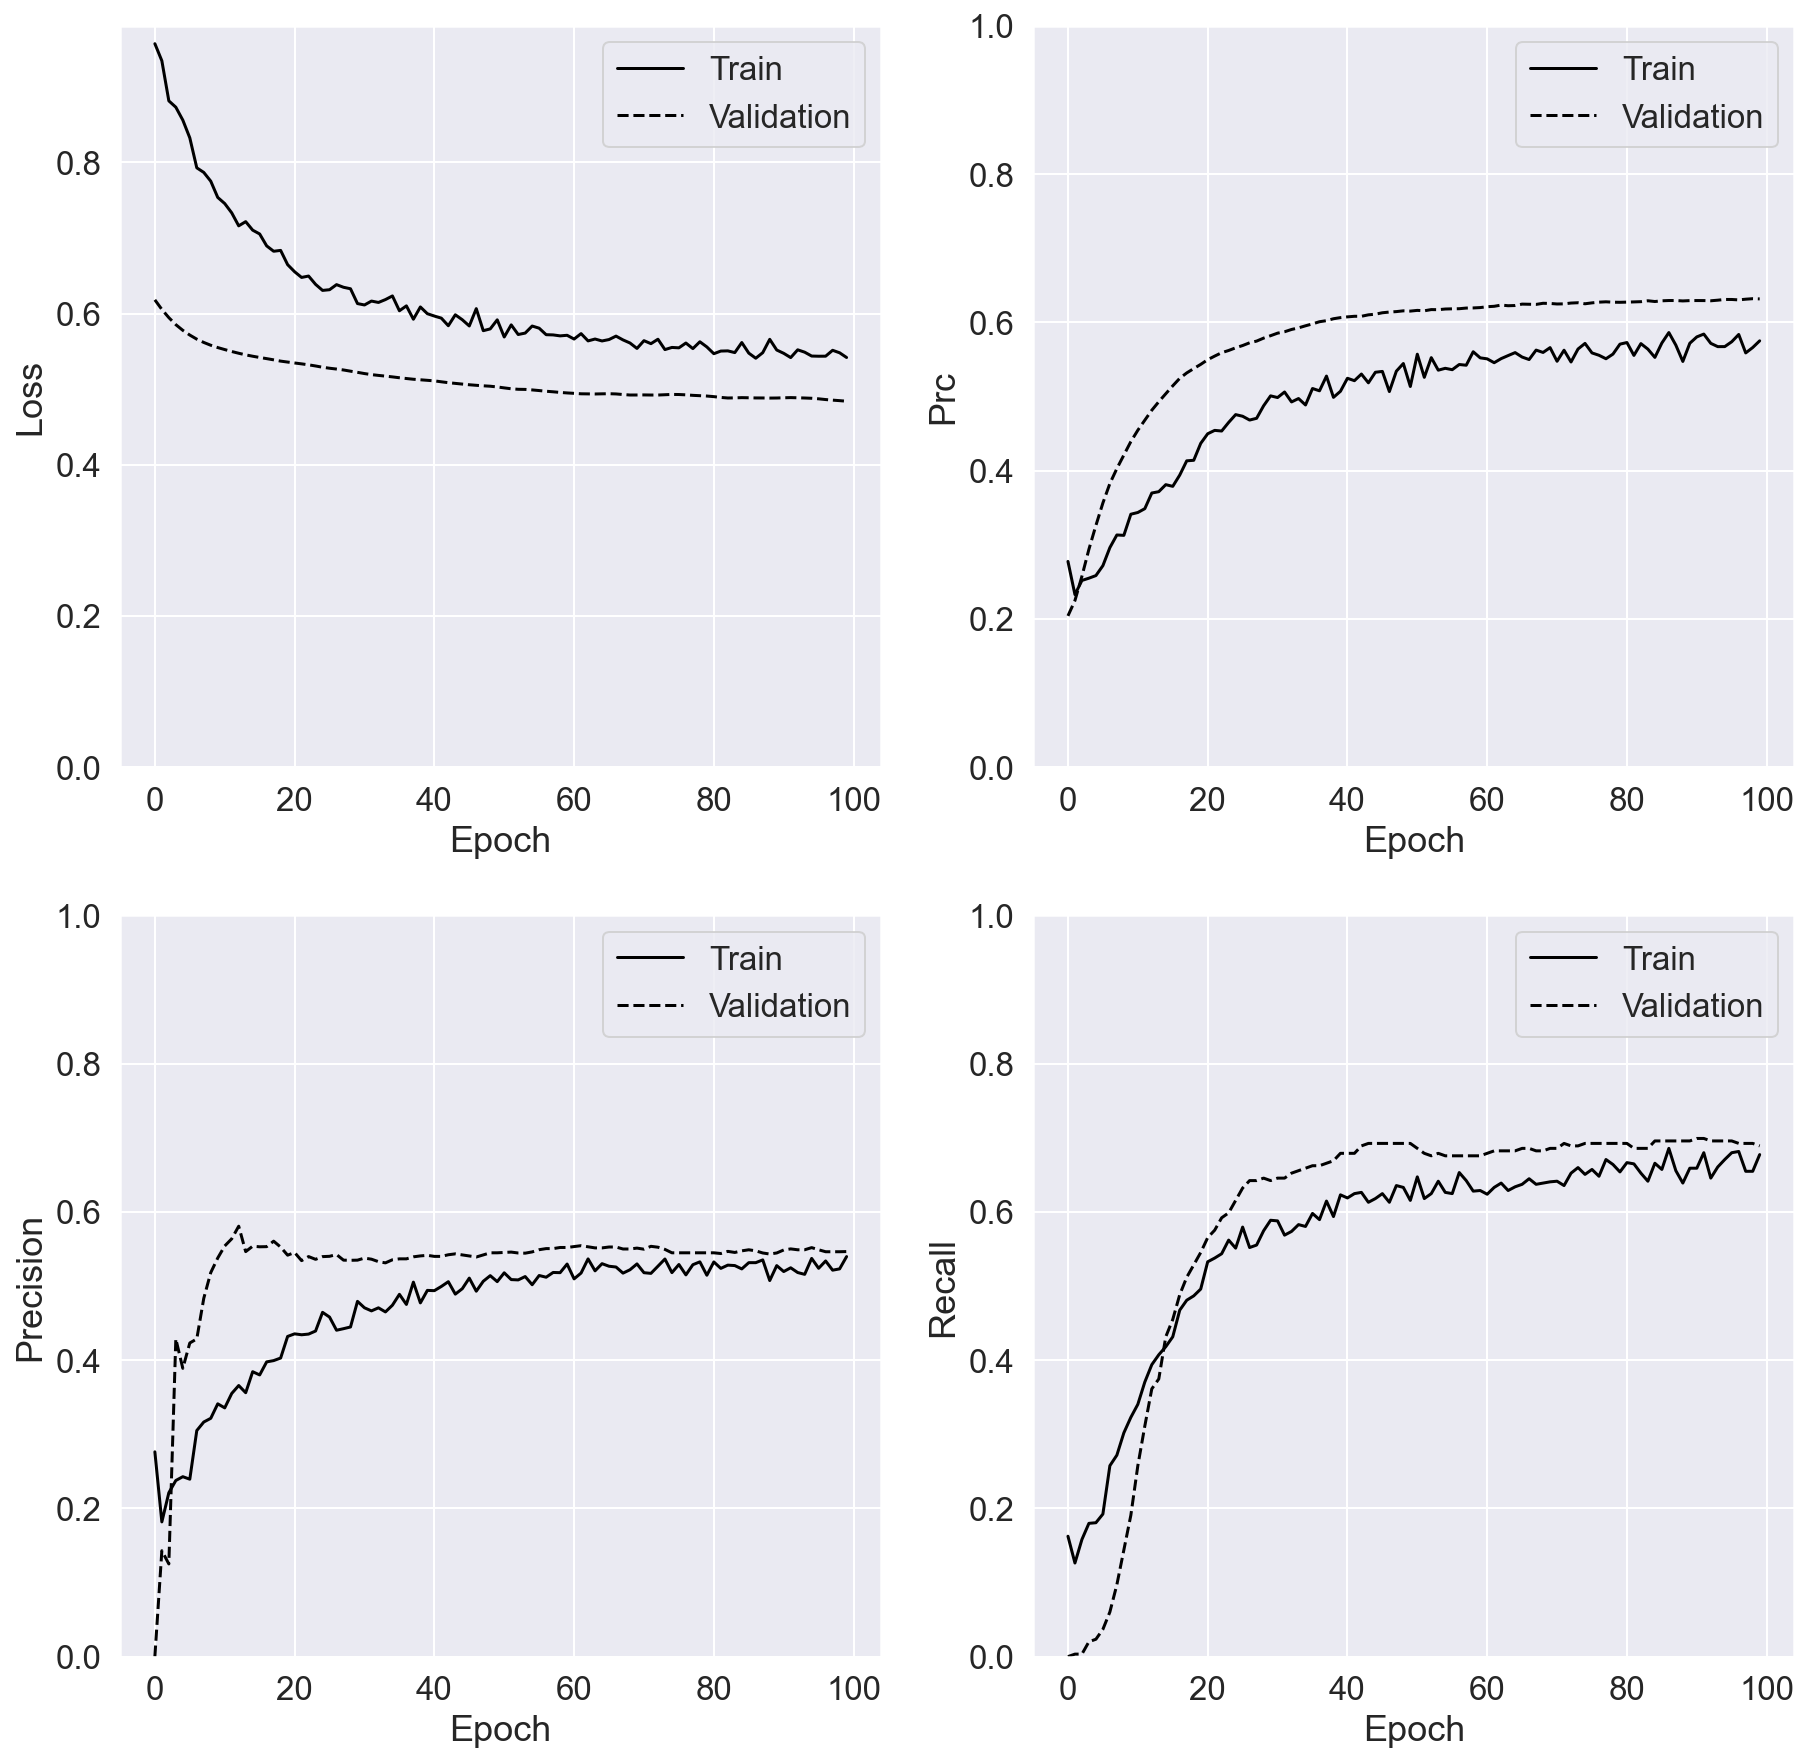

In [41]:
PlotMetrics(weighted_history)

In [42]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.4725993871688843
tp :  263.0
fp :  202.0
tn :  831.0
fn :  111.0
accuracy :  0.7775408625602722
precision :  0.5655913949012756
recall :  0.7032085657119751
auc :  0.8401545286178589
prc :  0.6474881172180176


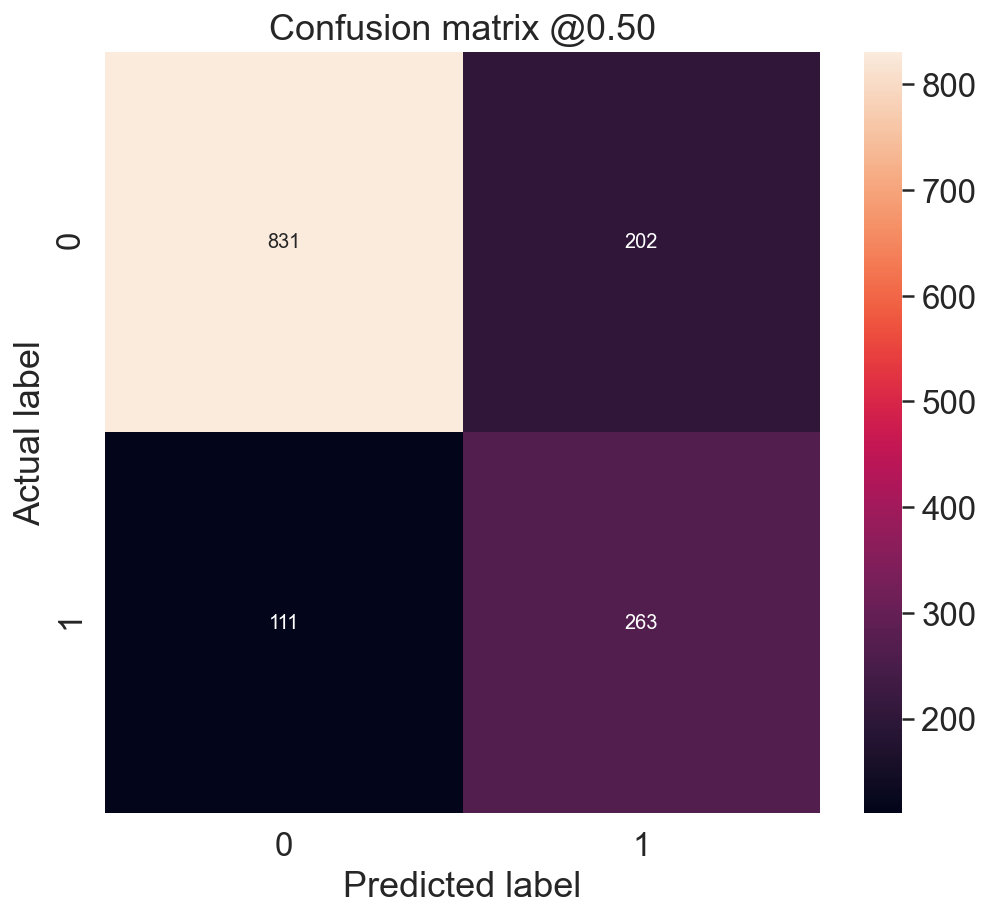

In [43]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_weighted)

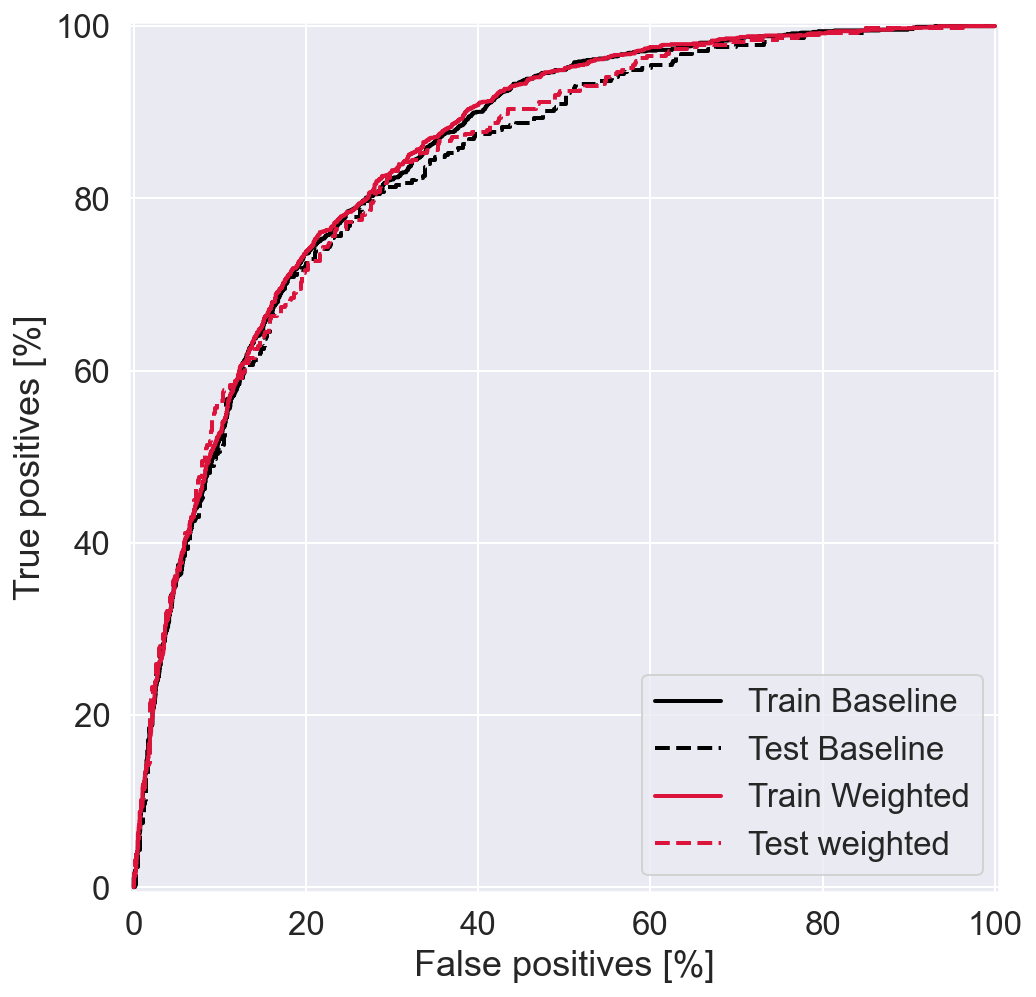

In [44]:
plt.figure(figsize=(8, 8))

PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotROC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotROC('Test weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower right')

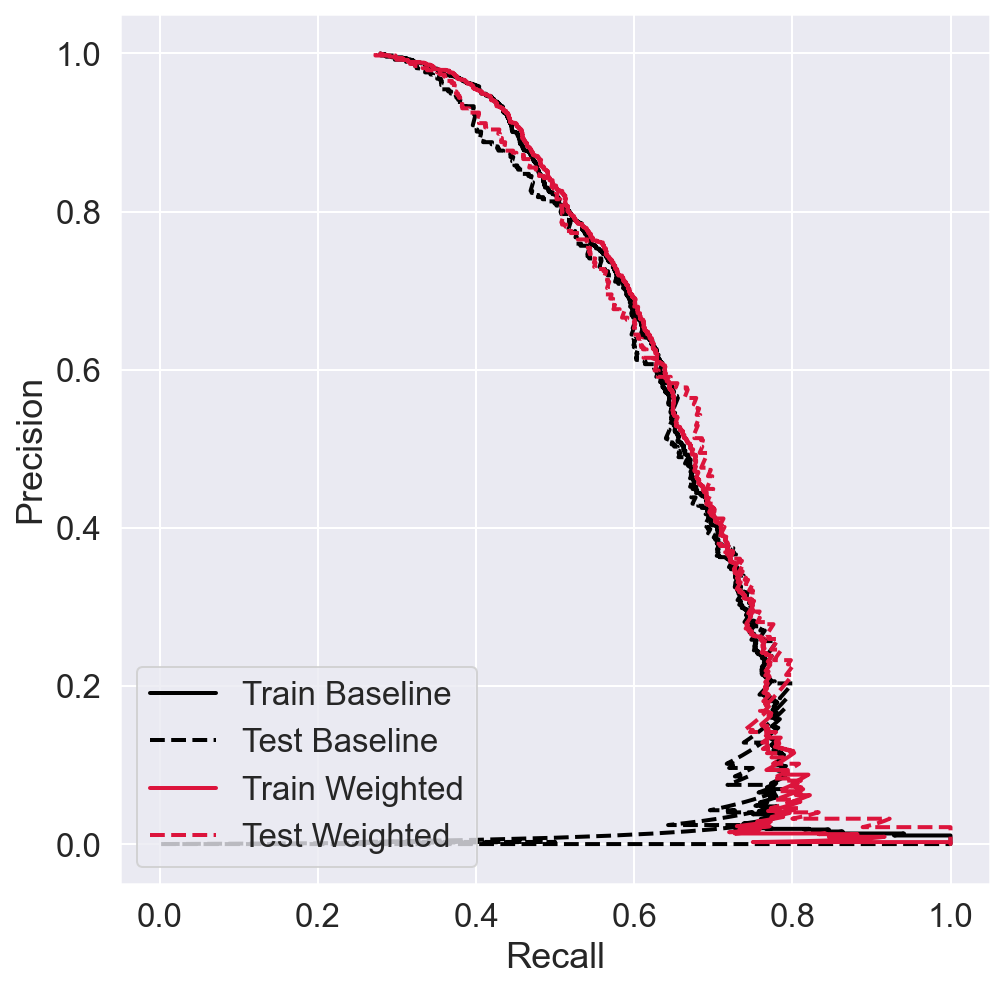

In [45]:
plt.figure(figsize=(8, 8))

PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotPRC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotPRC('Test Weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower left')